In [130]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from scipy.stats import binned_statistic, powerlaw, binned_statistic_2d
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import quad
import kmeans_radec
from astropy.io import ascii, fits
from scipy.constants import c as speed_of_light

import Setup as p

### Work out the failure rate

In [115]:
def survival_failedMstar(dist, logMHlim, nbins, window_length, polyorder):
    bins_dist = np.linspace(np.min(dist), np.max(dist), nbins+1)
    bins_logMH = np.linspace(logMH.min(), logMH.max(), nbins+1)

    x_dist = p.bin_centers(bins_dist)
    y_logMH = p.bin_centers(bins_logMH)

    # Find the missing galaxies
    IDS = np.where(np.isfinite(MS)==False)
    remDist = dist[IDS]
    remHI = logMH[IDS]
    # Calculate 2D binned statistics
    stat =  binned_statistic_2d(x=remDist, y=remHI, values=remDist, statistic='count', bins=[bins_dist, bins_logMH])[0]
    stat_norm = binned_statistic_2d(x=dist, y=logMH, values=dist, statistic='count', bins=[bins_dist, bins_logMH])[0]
    # From where start integrating masses
    xi = np.abs(y_logMH-logMHlim).argmin()
    # Get some arrays to store results
    fail_gal = np.zeros(nbins)
    tot_gal = np.zeros(nbins)
    fail_rate = np.ones(nbins)

    for i in range(nbins):
        for j in range(xi, nbins):
            fail_gal[i] += stat[i, j]
            tot_gal[i] += stat_norm[i, j]
    
    IDS = np.where(tot_gal != 0)
    fail_rate[IDS] = 1 - fail_gal[IDS]/tot_gal[IDS]
    
    smooth_fail = savgol_filter(fail_rate, window_length, polyorder)
    finterp = interp1d(x_dist, smooth_fail, bounds_error=False, fill_value='extrapolate')

    return finterp(dist)

### Work out the HI selection

In [123]:
# Calculate HI selection function
MFWascii = ascii.read("../../Data/BMmatching/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

# Func to calculate m_HI,lim(d, w50)
def limit_logMH(d, w50):
    # Is this luminosity distance?
    if w50 <= 2.5:
        logflux = 0.5*w50-1.207
    elif w50 > 2.5:
        logflux = w50-2.457
    return 5.372+logflux+2*np.log10(d)

def surv_dist_HI(dist, minmass):
    res = 0
    norm = 0
    mlow_ind = np.abs(minmass-np.array(massbins)).argmin()

    for i in range(len(w50bins)-1):
        dw50 = w50bins[i+1]-w50bins[i]
        w50 = (w50bins[i+1]+w50bins[i])/2

        mlim = limit_logMH(dist, w50)

        mlim_ind = np.abs(mlim-np.array(massbins)).argmin()

        if mlim < minmass:
            xi = mlow_ind
        else:
            xi = mlim_ind

        for j in range(xi, len(massbins)-1):
            dm = massbins[j+1]-massbins[j]
            res += MFW[j, i]*dm*dw50

        for j in range(mlow_ind, len(massbins)-1):
            dm = massbins[j+1]-massbins[j]
            norm += MFW[j, i]*dm*dw50

    return res/norm

### Work out the RFI interference

In [127]:
# Sun's velocity vector
vsun = 369
RAsun= (11+11/60+57/60**2)*np.pi/12
DECsun = np.deg2rad(7.22)

def heliovelocity(pars):
    RAcmb, DECcmb, distcmb = pars
    cos_theta = np.cos(DECcmb)*np.cos(DECsun)*np.cos(RAcmb-RAsun)+np.sin(DECcmb)*np.sin(DECsun)
    return H0*distcmb-vsun*cos_theta

dataRFI = ascii.read("../../Data/BMmatching/rfi_frac.ascii")

rfi_hvel = np.array(dataRFI['Vhelio'])
rfi = np.array(dataRFI['fRFI'])

survival_func_rfi = interp1d(rfi_hvel, rfi, bounds_error=False, fill_value='extrapolate')

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/BMmatching/rfi_frac.ascii'

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


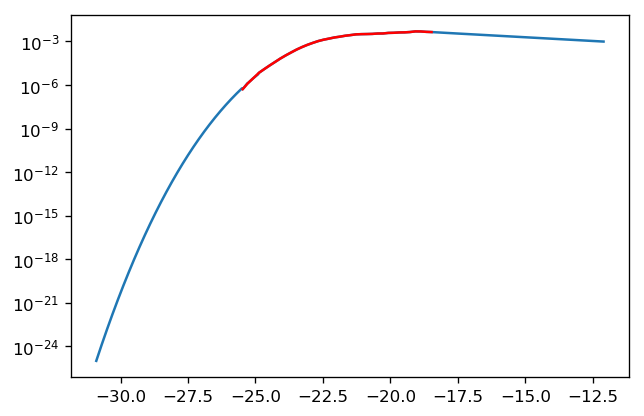

In [128]:
dataLF = np.loadtxt("../../Data/SMmatching/LF_Ser.dat")
# In https://arxiv.org/pdf/1304.7778.pdf h=0.7. Convert to preferred hubble units.
xLF = dataLF[:, 0] + 5*np.log10(0.7)
yLF = dataLF[:, 1] 

# Extrapolate the faint and bright end
def bright_end_func(x, a, b, c, d):
    return -np.exp(a*x+b) + c*x + d

def faint_end_func(x, a, b):
    return a*x+b

xmax = 29
bright_end_coef = curve_fit(bright_end_func, xLF[:xmax], yLF[:xmax], [[1, 0, 0, 0]], maxfev=100000)[0]
s = slice(-3, None)
faint_end_coef = curve_fit(faint_end_func, xLF[s], yLF[s], [0, 0], maxfev=100000)[0]


tbright = np.arange(-24.7-0.2, -31, -0.2)
a, b, c, d = bright_end_coef
ybright = [bright_end_func(i, a, b, c, d) for i in tbright]

tfaint = np.arange(-17.5, -12, 0.2)
a, b = faint_end_coef
yfaint = [faint_end_func(i, a, b) for i in tfaint]

# Merge the arrays
xx = np.hstack([tfaint, xLF, tbright])
yy = np.hstack([yfaint, yLF, ybright])

IDS = np.argsort(xx)
xx = xx[IDS]
yy = yy[IDS]

# Extrapolated luminosity function
nlum = interp1d(xx, 10**yy, kind='cubic')


plt.figure(dpi=120)
plt.semilogy(xx, 10**yy)
plt.semilogy(xLF, 10**yLF, c='red')
plt.show()

In [132]:
h = 1
H0 = 100*h

# Unpack catalog properties
matched_cat = fits.open("../../BAM/a100springfull.fits")[1].data
logMH = matched_cat['logMH']
MS = matched_cat['SERSIC_MASS']
RA = matched_cat['RAdeg_HI']
DEC = matched_cat['DECdeg_HI']
dist = matched_cat['Dist']*0.7
appmag = matched_cat['petroMag_r']

# Take only the ones with finite SM
IDS = np.where(np.isfinite(MS))
RA = RA[IDS]
DEC = DEC[IDS]
dist = dist[IDS]
logMH = logMH[IDS]
logMS = np.log10(MS[IDS])
appmag = appmag[IDS]

logMB = np.log10(10**logMS+1.4*10**logMH)

In [131]:
def redshift2distance(z):
    omega_m = 0.295
    omega_lambda = 0.705
    omega_k = 0.0
    H0 = h*100
    Dh = speed_of_light*1e-3/(H0)
    num = lambda z_prime : 1/np.sqrt(omega_m*(1+z_prime)**3+omega_k*(1+z_prime)**2+omega_lambda)
    quadnum = quad(num, 0, z)[0]
    comoving_distance = Dh*quadnum
    return comoving_distance

xx_redshift = np.linspace(0, 1, 10000)
yy_comoving = np.array([redshift2distance(i) for i in xx_redshift])

distance2redshift = interp1d(yy_comoving, xx_redshift)

def func_absmag(appmag, comoving_dist):
    # Return absolute magnitude for a given apparent magnitude and comoving distance
    z = distance2redshift(comoving_dist)
    luminosity_distance = (1+z)*comoving_dist
    return appmag-25-5*np.log10(luminosity_distance)


def surv_dist_Mstar(dist, Mmax, Mmin):
    Mlim = func_absmag(17.6, dist)
    if Mlim > Mmax:
        return 1
    else:
        norm = np.abs(quad(nlum, Mmax, Mmin)[0])
        num = np.abs(quad(nlum, Mlim, Mmin)[0])
        return num/norm

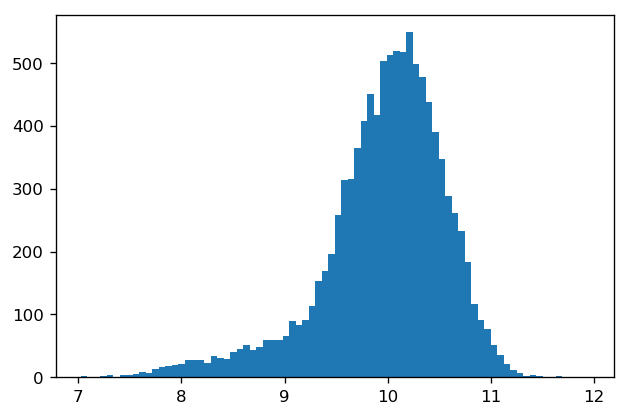

In [133]:
plt.figure(dpi=120)
plt.hist(logMB, bins='auto')
plt.show()

In [ ]:
N = 20
stat, bin_edges, __ = binned_statistic(logMB, logMH, bins=N, statistic=np.mean)
statstd, bin_edges, __ = binned_statistic(logMB, logMH, bins=N, statistic=np.std)

bin_centers = p.bin_centers(bin_edges)

lowbound = stat-2*statstd

MB2MHI_func = interp1d(bin_centers, lowbound)



plt.figure(dpi=120)
plt.scatter(logMB, logMH, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, lowbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_B/M_\odot$")
plt.ylabel(r"$\log_{10}M_H /M_\odot$")
plt.show()

In [ ]:
def func_absmag(appmag, d):
    # Distance in Mpc
    return appmag-25-5*np.log10(d)

absmag = list()
for i, j in zip(apmag, dist):
    absmag.append(func_absmag(i, j))
absmag = np.array(absmag)

In [ ]:
stat, bin_edges, __ = binned_statistic(logMB, logMS, bins=15)
statstd, bin_edges, __ = binned_statistic(logMB, logMS, bins=15, statistic=np.std)
bin_centers = p.bin_centers(bin_edges)

lowerbound = stat-2*statstd

MB2MS_func = interp1d(bin_centers, stat)
# MB2MS_func2 = interp1d(bin_centers, stat)

plt.figure(dpi=120)
plt.scatter(logMB, logMS, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, lowerbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_B/M_\odot$")
plt.ylabel(r"$\log_{10}M_*/M_\odot$")
plt.show()

In [ ]:
stat, bin_edges, __ = binned_statistic(logMS, absmag, bins=15)
statstd, bin_edges, __ = binned_statistic(logMS, absmag, bins=15, statistic=np.std)
bin_centers = p.bin_centers(bin_edges)

upperbound = stat+2*statstd

MS2absmag_func = interp1d(bin_centers, upperbound)

plt.figure(dpi=120)
plt.scatter(logMS, absmag, s=0.05)
plt.plot(bin_centers, stat, c='red', marker='o')
plt.plot(bin_centers, upperbound, c='violet', marker='o')
plt.xlabel(r"$\log_{10}M_*/M_\odot$")
plt.ylabel(r"$M_r$")
plt.show()

In [ ]:
# Get pixel coverage for the random catalog
nside=25
hpmap = np.zeros(hp.nside2npix(nside))
active_pixs = list()
for r, d in zip(np.deg2rad(RA), np.deg2rad(DEC)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    hpmap[pix] = 1
    active_pixs.append(pix)
    
hp.mollview(hpmap, rot=180, cbar=False, title='')
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.05, c='red')

active_pixs = np.unique(np.array(active_pixs))

In [ ]:
num = 2
logMBlim = cuts[num]
perc = perc_list[num]
print("logMBlim", logMBlim)
logMHlim = MB2MHI_func(logMBlim)
logMSlim = MB2MS_func(logMBlim)
absmaglim = MS2absmag_func(logMSlim)
print("logMHIlim", logMHlim, "logMSlim", logMSlim,"absmaglim", absmaglim)


dist_arr = np.linspace(0.1, dist.max(), 1000)

y1 = SelectionFunc.survival_func_HI(dist_arr, logMHlim, 151)(dist_arr)
y2coarse, y2smooth, y2func = SelectionFunc.survival_rate(dist_arr, logMHlim, logMH.max(), 451, 3)
y2 = y2func(dist_arr)
y3 = SelectionFunc.survival_func_SM(dist_arr, absmaglim)(dist_arr)

y = y1*y2*y3
surv_func = interp1d(dist_arr, y)


plt.figure(dpi=120, figsize=(10,3.5))

plt.subplot(121)
plt.plot(dist_arr, y3, label=r"$\mathrm{MS}$")
plt.plot(dist_arr, y1, label=r"$\mathrm{HI}$")
plt.plot(dist_arr, y2, label=r"$\mathrm{Fail.}$")
plt.plot(dist_arr, y, label=r"$\mathrm{HI}\times\mathrm{MS}\times \mathrm{Fail.}$")
plt.ylabel(r"$\varphi(d)$")
plt.xlabel(r"$\mathrm{Distance}/\mathrm{Mpc}$")
plt.legend()

plt.subplot(122)
plt.plot(dist_arr, y2coarse)
plt.plot(dist_arr, y2smooth)

plt.show()


In [ ]:
# Generate a random catalog
Nrands = 5e6
Nrands_target = int(Nrands/0.75)
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
Pmin = (np.sin(np.deg2rad(DEC.min()))+1)/2
Pmax = (np.sin(np.deg2rad(DEC.max()))+1)/2
distmin, distmax = dist.min(), dist.max()

randRA = np.random.uniform(RAmin, RAmax, Nrands_target)
randDEC = np.arcsin(2*np.random.uniform(Pmin, Pmax, size=Nrands_target)-1)
randdist = powerlaw.rvs(a=3, loc=distmin, scale=distmax-distmin, size=Nrands_target)

# Eliminate galaxies in pixels not covered by the ALFALFA survey
pixels = hp.ang2pix(nside, np.pi/2-randDEC, randRA)
IDS = np.where(np.isin(pixels, active_pixs)==True)
# Switch to degrees
randRA= np.rad2deg(randRA[IDS])
randDEC = np.rad2deg(randDEC[IDS])
randdist = randdist[IDS]

# Cluster the galaxies for jackknifing
N = randRA.size
Ncluster = 10000
IDS = np.random.choice(np.arange(N), Ncluster, False)
X = np.vstack([randRA[IDS], randDEC[IDS]]).T
km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

X = np.vstack([randRA, randDEC]).T
randLabels = km.find_nearest(X)

hp.mollview(np.zeros(12), rot=180, title='', cbar=False)
for label in np.unique(km.labels):
    IDSlab = np.where(km.labels==label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS][IDSlab]), np.deg2rad(randRA[IDS][IDSlab]), s=0.5)
    
# Apply selection effects to the rand.
N = randdist.size
print(N)

prob_surv = surv_func(randdist)
# Don't forget RFI..
hvel = list()
for r, d, distance in zip(np.deg2rad(randRA), np.deg2rad(randDEC), randdist):
    hvel.append(SelectionFunc.heliovelocity([r, d, distance]))
hvel = np.array(hvel)

prob_rfi = SelectionFunc.survival_func_rfi(hvel)
# prob_rfi=1

prob_arr = prob_surv*prob_rfi
rand_arr = np.random.uniform(0, 1, N)

IDS = np.where((prob_arr-rand_arr) > 0)
randdist = randdist[IDS]
randRA = randRA[IDS]
randDEC = randDEC[IDS]
randLabels = randLabels[IDS]
print(randdist.size)

In [ ]:
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

number_density = 0
mlow_ind = np.abs(logMHlim-np.array(massbins)).argmin()

for i in range(len(w50bins)-1):
    dw50 = w50bins[i+1]-w50bins[i]
    w50 = (w50bins[i+1]+w50bins[i])/2

    for j in range(mlow_ind, len(massbins)-1):
        dm = massbins[j+1]-massbins[j]
        number_density += MFW[j, i]*dm*dw50

print("Number density is {}".format(number_density))

J3 = 2962

def get_weights(dist):
    return 1/(1+4*np.pi*number_density*J3*surv_func(dist))

plt.figure(dpi=120, figsize=(9,3))

plt.subplot(121)
plt.plot(dist_arr, get_weights(dist_arr))

plt.subplot(122)
plt.hist(get_weights(dist), bins='auto')

plt.show()

In [ ]:
# Plot how do the histograms differ
IDS = np.where(logMB>logMBlim)
print("N. gal above this mass cut", IDS[0].size)


# Downsample randcat to the same size as catalog
IDS2 = np.random.choice(np.arange(randdist.size), dist[IDS].size, replace=False)

# plt.figure(figsize=(figwidth, figheight) ,dpi=240)
plt.figure(dpi=120)

plt.hist(dist[IDS], bins='auto', label="Obs. sample")
plt.hist(randdist[IDS2], bins='auto', label="Rand. sample", alpha=0.5)
plt.ylabel(r"Counts")
plt.xlabel(r"Distance$/\mathrm{Mpc}$")
plt.xlim(dist[IDS].min(), dist[IDS].max())
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
N = randdist.size
random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA
random_catalog['dec'] = randDEC
random_catalog['dist'] = randdist
random_catalog['label'] = randLabels
# random_catalog['weights'] = np.ones_like(randRA)
random_catalog['weights'] = get_weights(randdist)

np.save("../../Data/BMmatching/CFrandcatBM_{}_.npy".format(perc), random_catalog)
print("We have {} galaxies in random.".format(N))

IDS = np.where(logMB>logMBlim)
N = dist[IDS].size
X = np.vstack([RA[IDS], DEC[IDS]]).T

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RA[IDS]
cut_catalog['dec'] = DEC[IDS]
cut_catalog['dist'] = dist[IDS]
cut_catalog['weights'] = get_weights(dist[IDS])
cut_catalog['label'] = km.find_nearest(X)
# cut_catalog['weights'] = np.ones_like(RAcut)

np.save("../../Data/BMmatching/CFcatBM_{}_.npy".format(perc), cut_catalog)
print("We have {} galaxies in observation.".format(N))

hp.mollview(np.zeros(12), rot=180)
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)

In [ ]:
!ls ../../Data/BMmatching/